<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview-of-the-patent-owners-for-each-disease" data-toc-modified-id="Overview-of-the-patent-owners-for-each-disease-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview of the patent owners for each disease</a></span><ul class="toc-item"><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import modules</a></span></li></ul></li><li><span><a href="#Loading-data-files" data-toc-modified-id="Loading-data-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading data files</a></span></li><li><span><a href="#Overall-historic-perspective" data-toc-modified-id="Overall-historic-perspective-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overall historic perspective</a></span></li><li><span><a href="#Historic-perspective-of-top-10-assignees" data-toc-modified-id="Historic-perspective-of-top-10-assignees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Historic perspective of top 10 assignees</a></span></li><li><span><a href="#Overview-of-top-patent-owners" data-toc-modified-id="Overview-of-top-patent-owners-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Overview of top patent owners</a></span></li></ul></div>

### Overview of the patent owners for each disease

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
sns.set(context='poster', style='dark')

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_normalized_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

chembl      surechembl          patent_id        date          ipc  \
0  CHEMBL3137316  SCHEMBL1707427  US-20140316139-A1  2014-10-23  C07D 213/89   
1  CHEMBL3137316  SCHEMBL1707427  US-20140142316-A1  2014-05-22  C07D 213/89   

  assignee organization_name acquired_by person  
0   PFIZER            Pfizer         NaN    NaN  
1   PFIZER            Pfizer         NaN    NaN

In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_normalized_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

chembl       surechembl          patent_id        date          ipc  \
0  CHEMBL1460470  SCHEMBL14919618  US-20140256767-A1  2014-09-11  C07D 401/14   
1  CHEMBL1460470  SCHEMBL14919618  US-20180148408-A1  2018-05-31  C07D 209/48   

       assignee   organization_name acquired_by person  
0  UNIV RUTGERS  Rutgers University         NaN    NaN  
1  UNIV RUTGERS  Rutgers University         NaN    NaN

Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 9), (76321, 9))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 9)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 9)

Count of each category

In [10]:
def get_assignee_category_count(df: pd.DataFrame):
    """Get dataframe with count of high-level assignee classification"""
    
    assignee_dict = defaultdict(set)
    
    for patent_idx, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'organization_name', 'acquired_by', 'person']].values
    ):

        if pd.notna(is_aquired):
            assignee_dict['acquired'].add(patent_idx)
        elif pd.notna(person_name):
            assignee_dict['individuals'].add(patent_idx)
        else:
            assert pd.notna(org), f"Some discepancy found in {patent_idx}!"
            assignee_dict['organisation'].add(patent_idx)
    
    assignee_dict = [
        {
            'assignee_type': assignee_type,
            'patent_count': len(patents)
        }
        for assignee_type, patents in assignee_dict.items()
    ]
    
    return pd.DataFrame(assignee_dict)

In [11]:
get_assignee_category_count(rare_disease_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 289188.31it/s]


assignee_type  patent_count
0  organisation           369
1   individuals            53
2      acquired            80

In [12]:
get_assignee_category_count(alzheimer_disease_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 277918.07it/s]


assignee_type  patent_count
0  organisation         10017
1   individuals          1778
2      acquired          1386

### Overall historic perspective

In [13]:
def get_historic_view(df: pd.DataFrame):
    """Create dataframe with patents filed per year."""
    
    year_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, org, is_aquired, is_person in tqdm(
        df[['patent_id', 'date', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split('-')[0]
        
        if pd.notna(is_person):
            assignee_type = 'individuals'
        elif pd.notna(is_aquired):
            assignee_type = 'acquired'
        else:
            assignee_type = 'organisations'
        
        year_dict[int(year)][assignee_type].add(patent_idx)
    
    year_data = []
    for year, assignee_dict in year_dict.items():
        year_data.append({
            'year': year,
            'total': len(assignee_dict['organisations']),
            'type': 'organisations'
        })
        
        year_data.append({
            'year': year,
            'total': len(assignee_dict['individuals']),
            'type': 'individuals'
        })
        
        year_data.append({
            'year': year,
            'total': len(assignee_dict['acquired']),
            'type': 'acquired'
        })
        
    return pd.DataFrame(year_data)

In [14]:
rare_disease_year_df = get_historic_view(rare_disease_data)
rare_disease_year_df.sort_values(by='year', inplace=True)
rare_disease_year_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 250891.77it/s]


year  total           type
65  2000      1       acquired
63  2000      6  organisations

In [15]:
alzheimer_disease_year_df = get_historic_view(alzheimer_disease_data)
alzheimer_disease_year_df.sort_values(by='year', inplace=True)
alzheimer_disease_year_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 277414.63it/s]


year  total           type
42  2000    150  organisations
43  2000      3    individuals

Visualisation

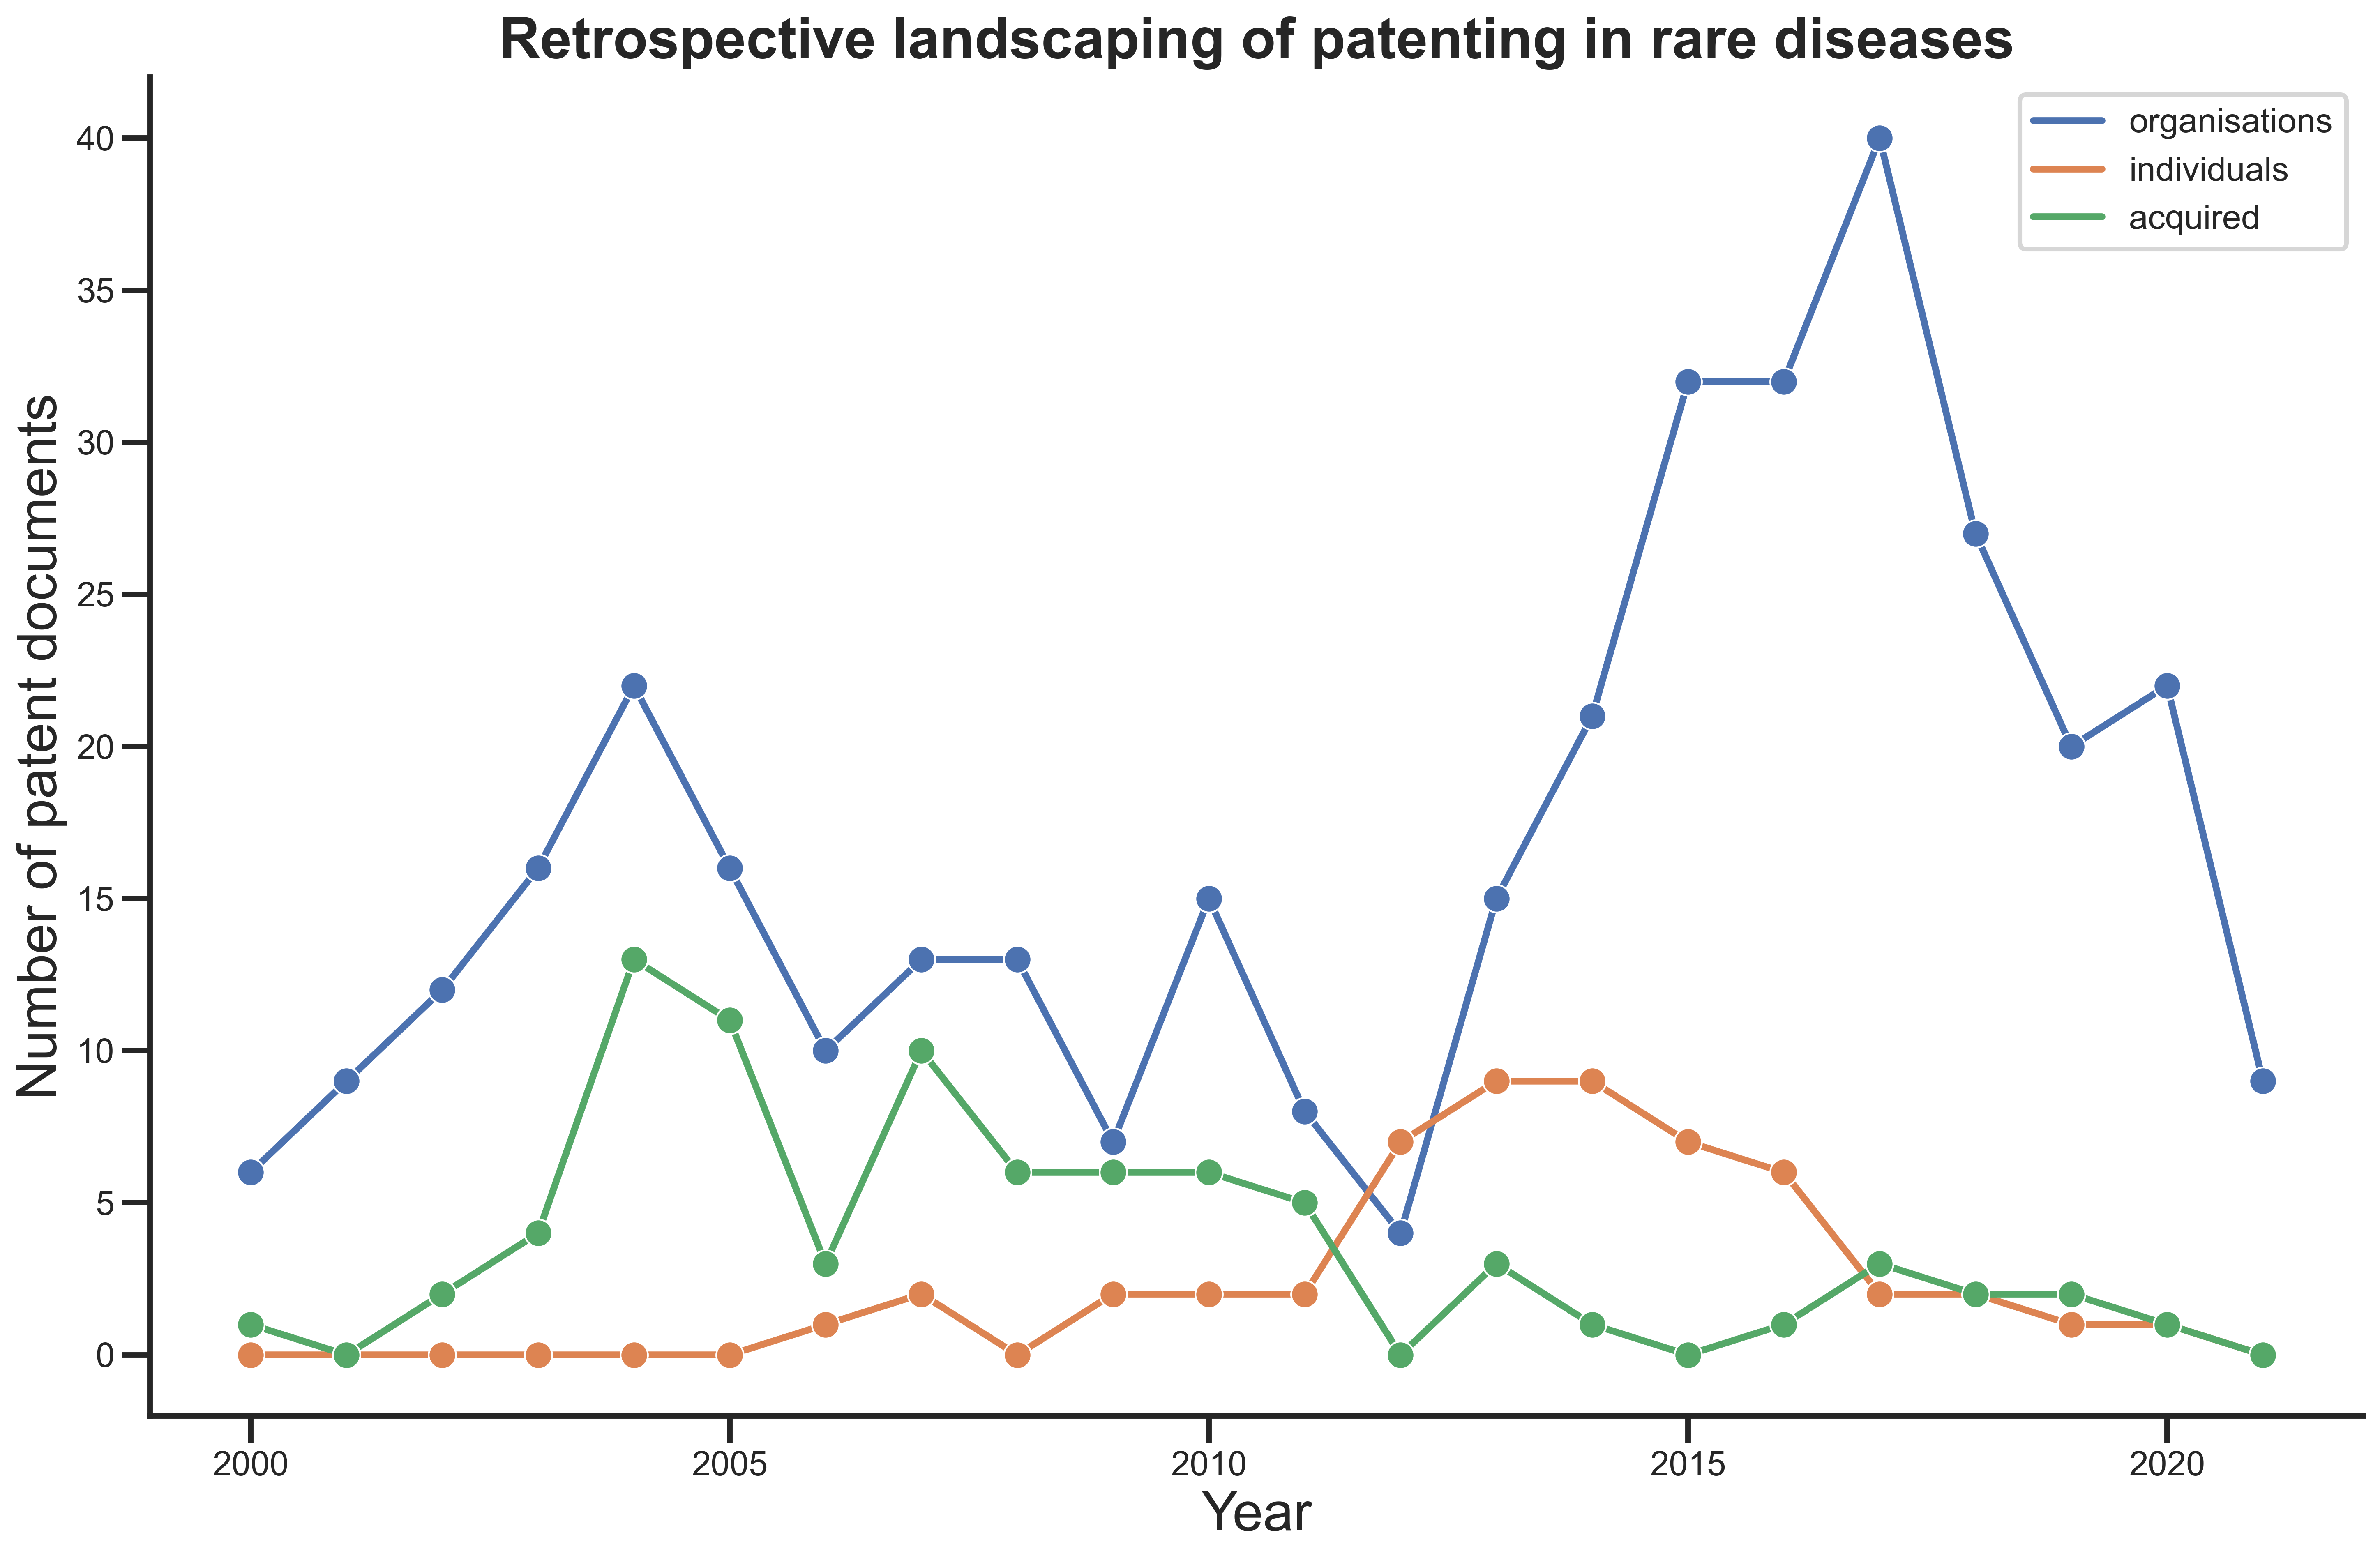

In [16]:
sns.set_style("ticks")

plt.figure(figsize=(15, 10))

sns.lineplot(
    data=rare_disease_year_df,
    x='year', y='total',
    hue="type", marker="o", hue_order=['organisations', 'individuals', 'acquired']
)
sns.despine()

plt.title(
    'Retrospective landscaping of patenting in rare diseases', 
    horizontalalignment='center', size=25,
    verticalalignment='center', weight='bold', pad=15
)
plt.xlabel('Year')
plt.ylabel('Number of patent documents')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
plt.tight_layout()

plt.savefig(
    f'{FIG_DIR}/figure_3.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

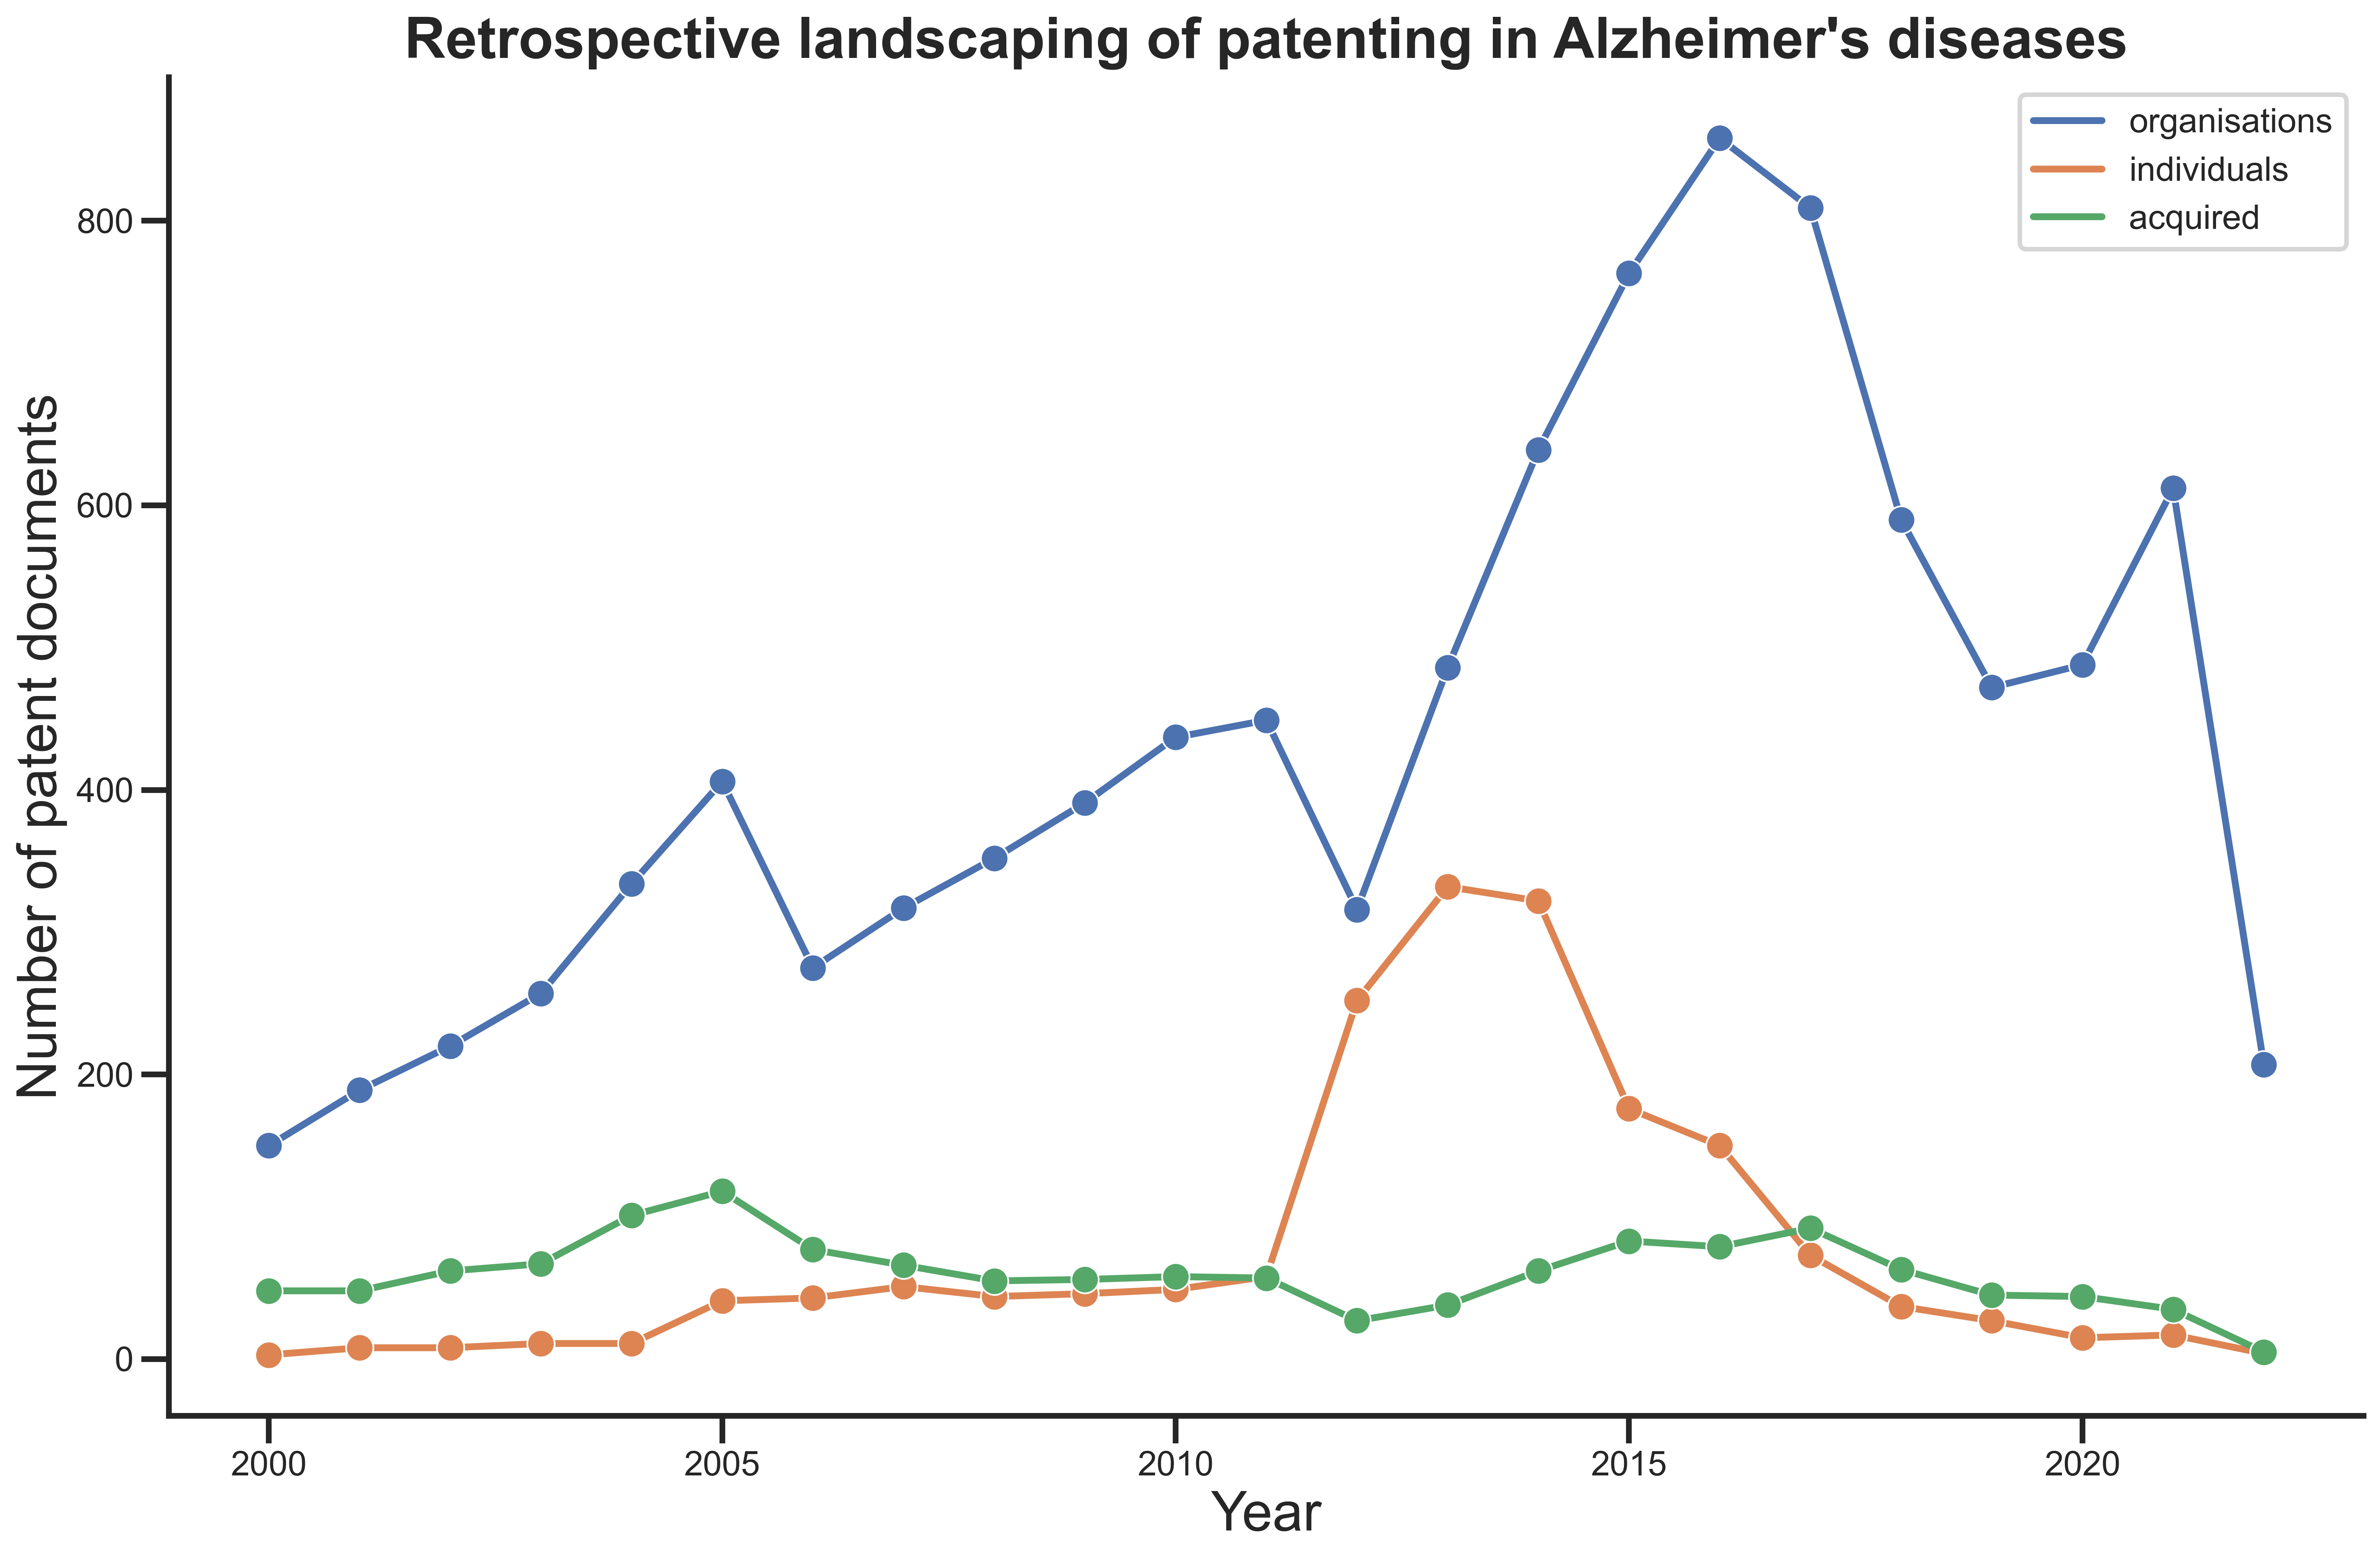

In [17]:
sns.set_style("ticks")

plt.figure(figsize=(15, 10))

sns.lineplot(
    data=alzheimer_disease_year_df,
    x='year', y='total',
    hue="type", marker="o", hue_order=['organisations', 'individuals', 'acquired']
)
sns.despine()

plt.title(
    "Retrospective landscaping of patenting in Alzheimer's diseases", 
    horizontalalignment='center', size=25,
    verticalalignment='center', weight='bold', pad=15
)
plt.xlabel('Year')
plt.ylabel('Number of patent documents')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
plt.tight_layout()

plt.savefig(
    f'{FIG_DIR}/figure_6.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

### Historic perspective of top 10 assignees

Patent document based assignee ranking 

In [18]:
def create_assignee_rank(df: pd.DataFrame):
    """Create assignee dataframe based on the no.of patent documents contributed."""
    
    assignee_dict = defaultdict(set)
    patent_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'date', 'assignee', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split("-")[0]
        
        if pd.notna(is_aquired):
            assignee_dict['acquired'].add(is_aquired)
            patent_dict[is_aquired][year].add(patent_idx)
        elif pd.notna(person_name):
            assignee_dict['individuals'].add(assignee)
            patent_dict[assignee][year].add(patent_idx)
        else:
            assert pd.notna(org), f"Some discepancy found in {patent_idx}!"
            assignee_dict['organisation'].add(org)
            patent_dict[org][year].add(patent_idx)
        
    patent_data = []
    for assignee_name, year_based_dict in patent_dict.items():
        if assignee_name in assignee_dict['organisation']:
            assignee_type = 'organisation'
        elif assignee_name in assignee_dict['acquired']:
            assignee_type = 'acquired'
        else:
            assert assignee_name in assignee_dict['individuals'], f"{assignee_name} not found!"
            assignee_type = 'individuals'
        
        # Get total patent count
        all_patents = set()
        for patents in year_based_dict.values():
            all_patents.update(patents)
        
        for year, year_patents in year_based_dict.items():
            patent_data.append({
                'assignee_name': assignee_name,
                'total_patent_count': len(all_patents),
                'assignee_type': assignee_type,
                'year': int(year),
                'annual_patent_count': len(year_patents)
            })
        
    return pd.DataFrame(patent_data)

In [19]:
rare_disease_assignee_rank = create_assignee_rank(rare_disease_data)
rare_disease_assignee_rank.sort_values(
    by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
rare_disease_assignee_rank.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 233299.61it/s]


assignee_name  total_patent_count assignee_type  year  annual_patent_count
6        Pfizer                  48  organisation  2000                    2

In [20]:
# Get top 10 assignees and sort by year
top_10_rare_disease_assignee = rare_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()

top_assignee_rare_disease = rare_disease_assignee_rank[
    rare_disease_assignee_rank['assignee_name'].isin(top_10_rare_disease_assignee)
]

In [21]:
alzheimers_disease_assignee_rank = create_assignee_rank(alzheimer_disease_data)
alzheimers_disease_assignee_rank.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
alzheimers_disease_assignee_rank.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 240399.01it/s]


assignee_name  total_patent_count assignee_type  year  annual_patent_count
332        Pfizer                 552  organisation  2000                    7

In [22]:
# Get top 10 assignees and sort by year

top_10_alzheimer_disease_assignee = alzheimers_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()

top_assignee_alzheimers_disease = alzheimers_disease_assignee_rank[
    alzheimers_disease_assignee_rank['assignee_name'].isin(top_10_alzheimer_disease_assignee)
]

Visualisation

In [23]:
def create_assignee_plot(df: pd.DataFrame, fig_num: str):
    sns.set(context='poster', style='dark')
    g = sns.FacetGrid(
        df, col='assignee_name', hue='assignee_name', col_wrap=2,
        aspect=2.5, palette='tab10'
    )

    g = g.map(plt.plot, 'year', 'annual_patent_count')

    # Fill the area with fill_between
    g = g.map(
        plt.fill_between, 'year', 'annual_patent_count', alpha=0.2
    )

    # Control the title of each facet
    g.set_titles("{col_name}")


    # Add a title for the whole plot
    plt.subplots_adjust(top=0.5)

    for i, ax in enumerate(g.axes):
        ax.set_xlabel('Year')
        if i == 4:
            ax.set_ylabel('Patent count')
        else:
            ax.set_ylabel('')
        inventor_name = ax.get_title()
        patent_count = df[df['assignee_name'] == inventor_name]['total_patent_count'].unique().tolist()[0]
        ax.set_title(f'{inventor_name} ({patent_count} patents)')
        ax.grid(False)

    g = g.fig.suptitle(
        'Evolution of the patents in top 10 patent inventors',
        horizontalalignment='center',
        verticalalignment='center', weight='bold'
    )
    
    plt.tight_layout()
    plt.savefig(
        f'{FIG_DIR}/figure_{fig_num}.png',
        dpi=400,
        bbox_inches='tight', 
    )

    plt.show()

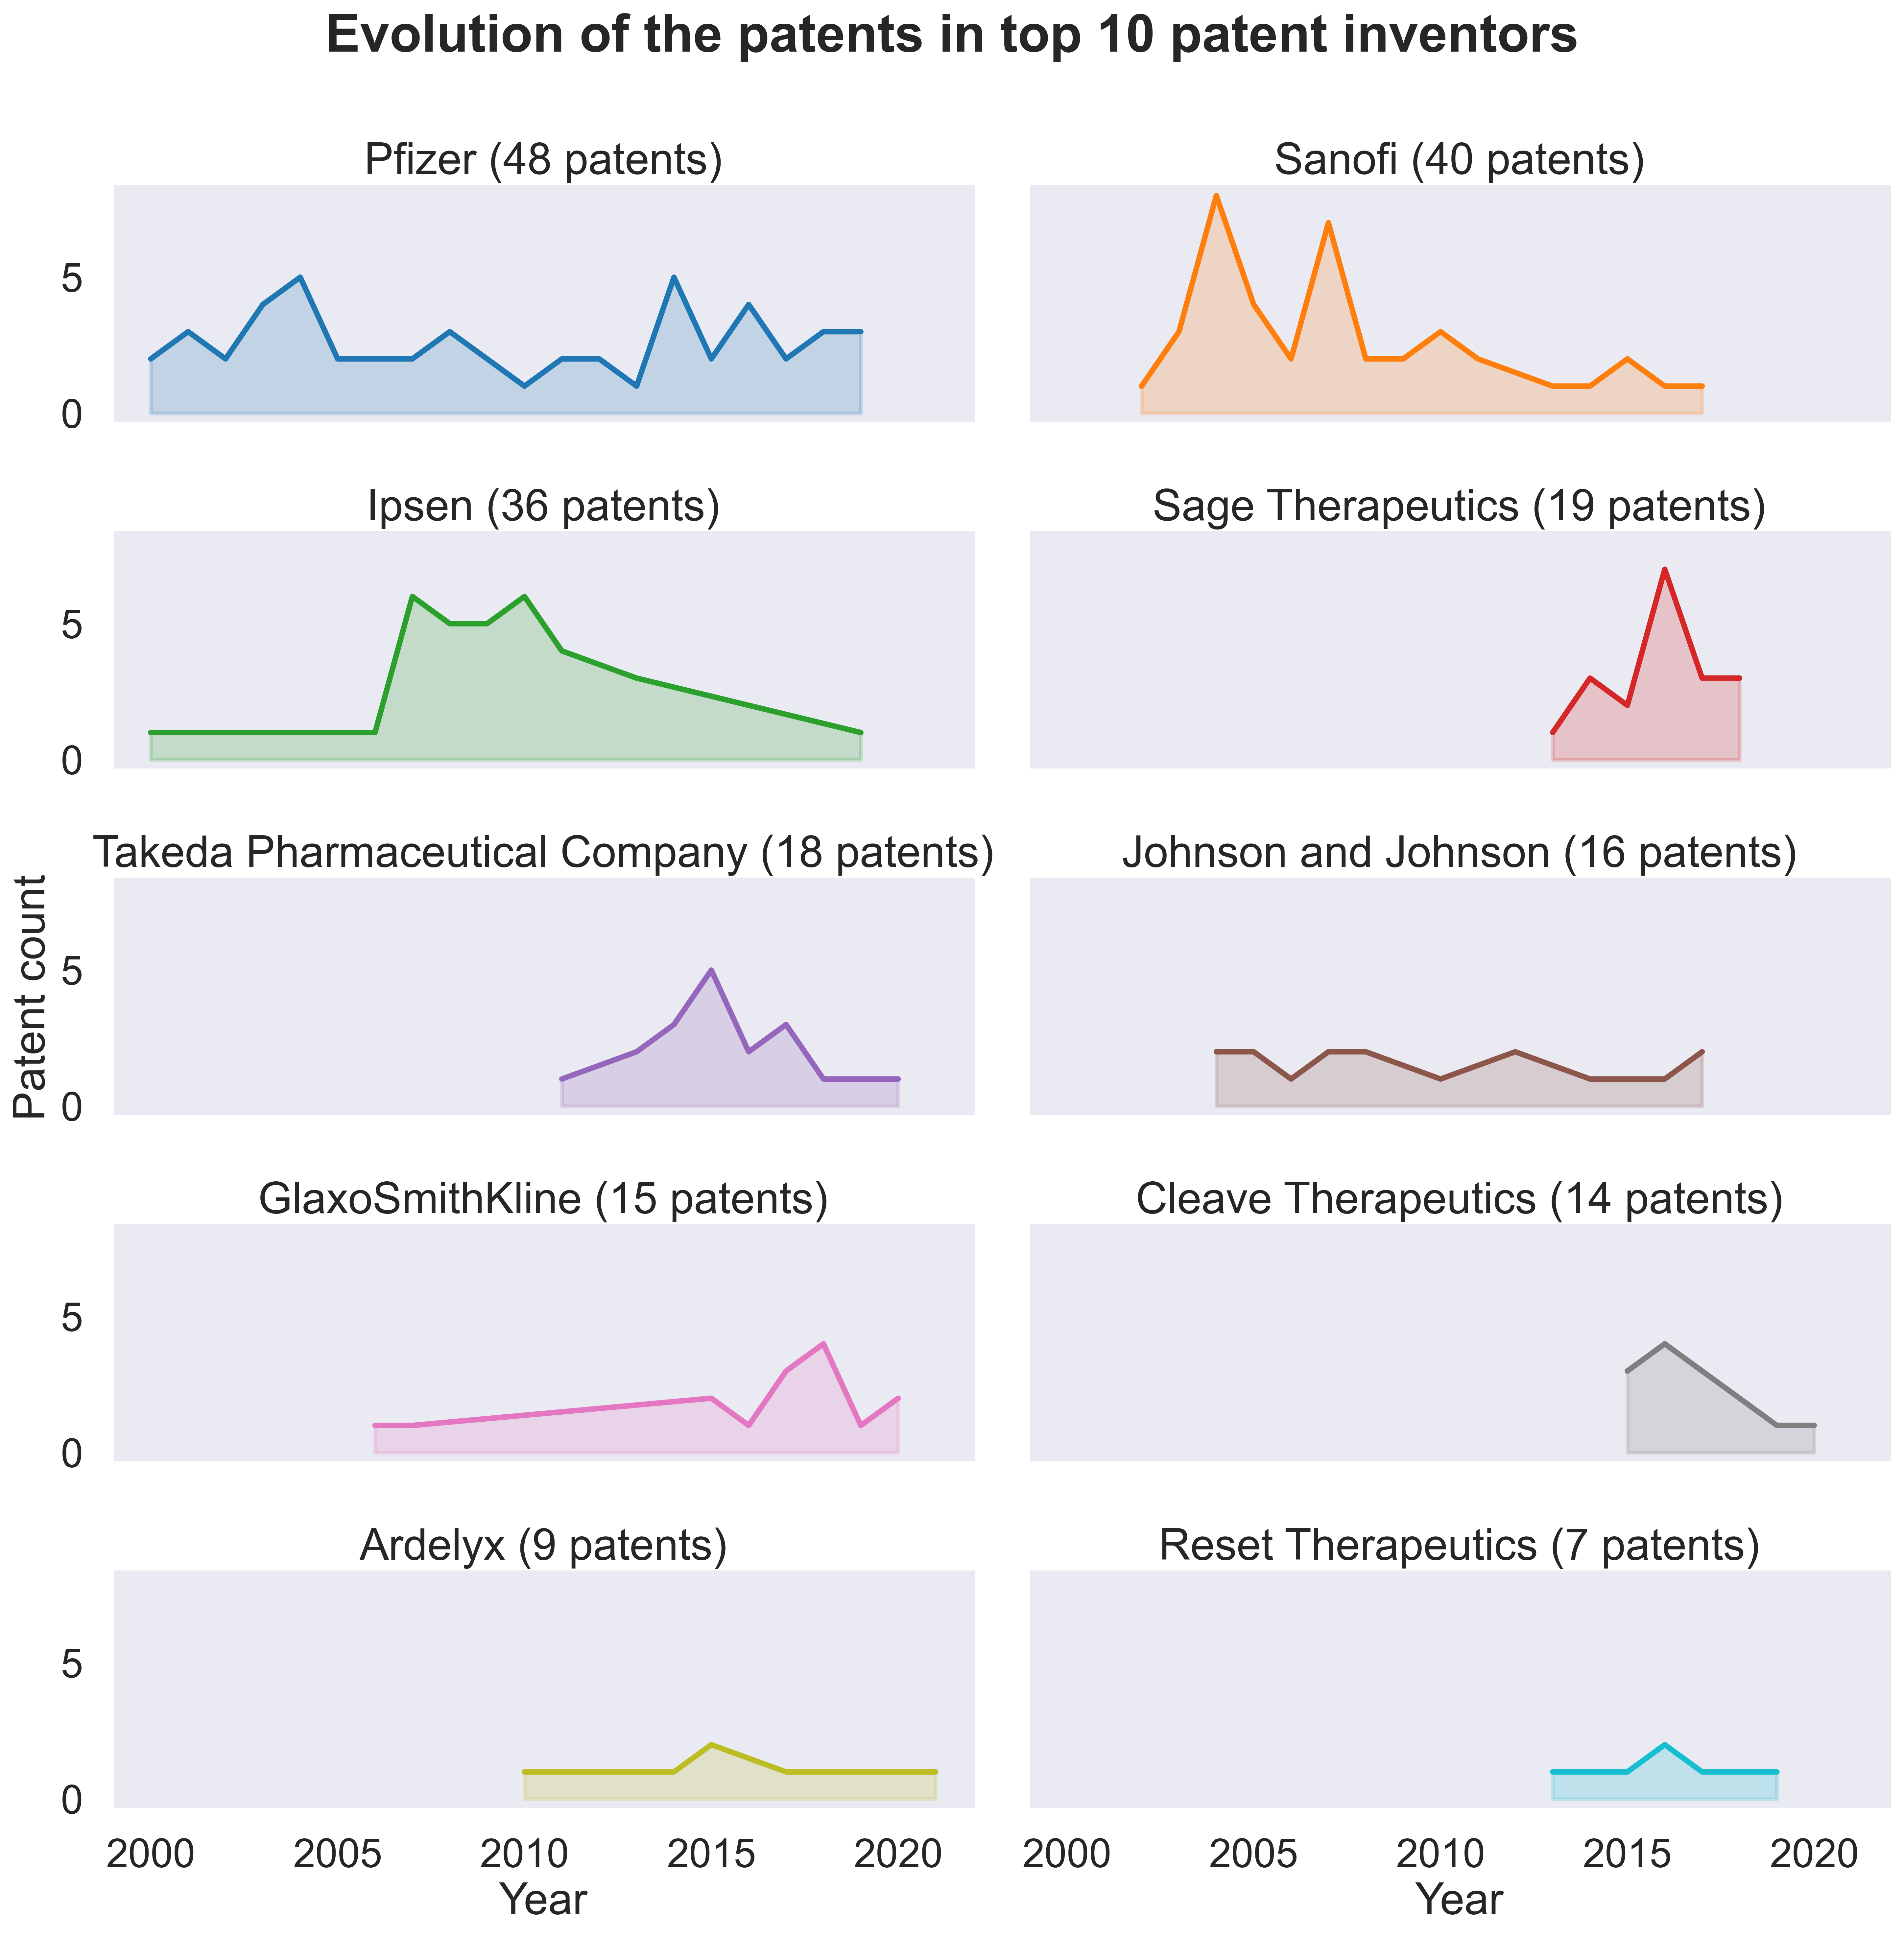

In [24]:
create_assignee_plot(top_assignee_rare_disease, '4')

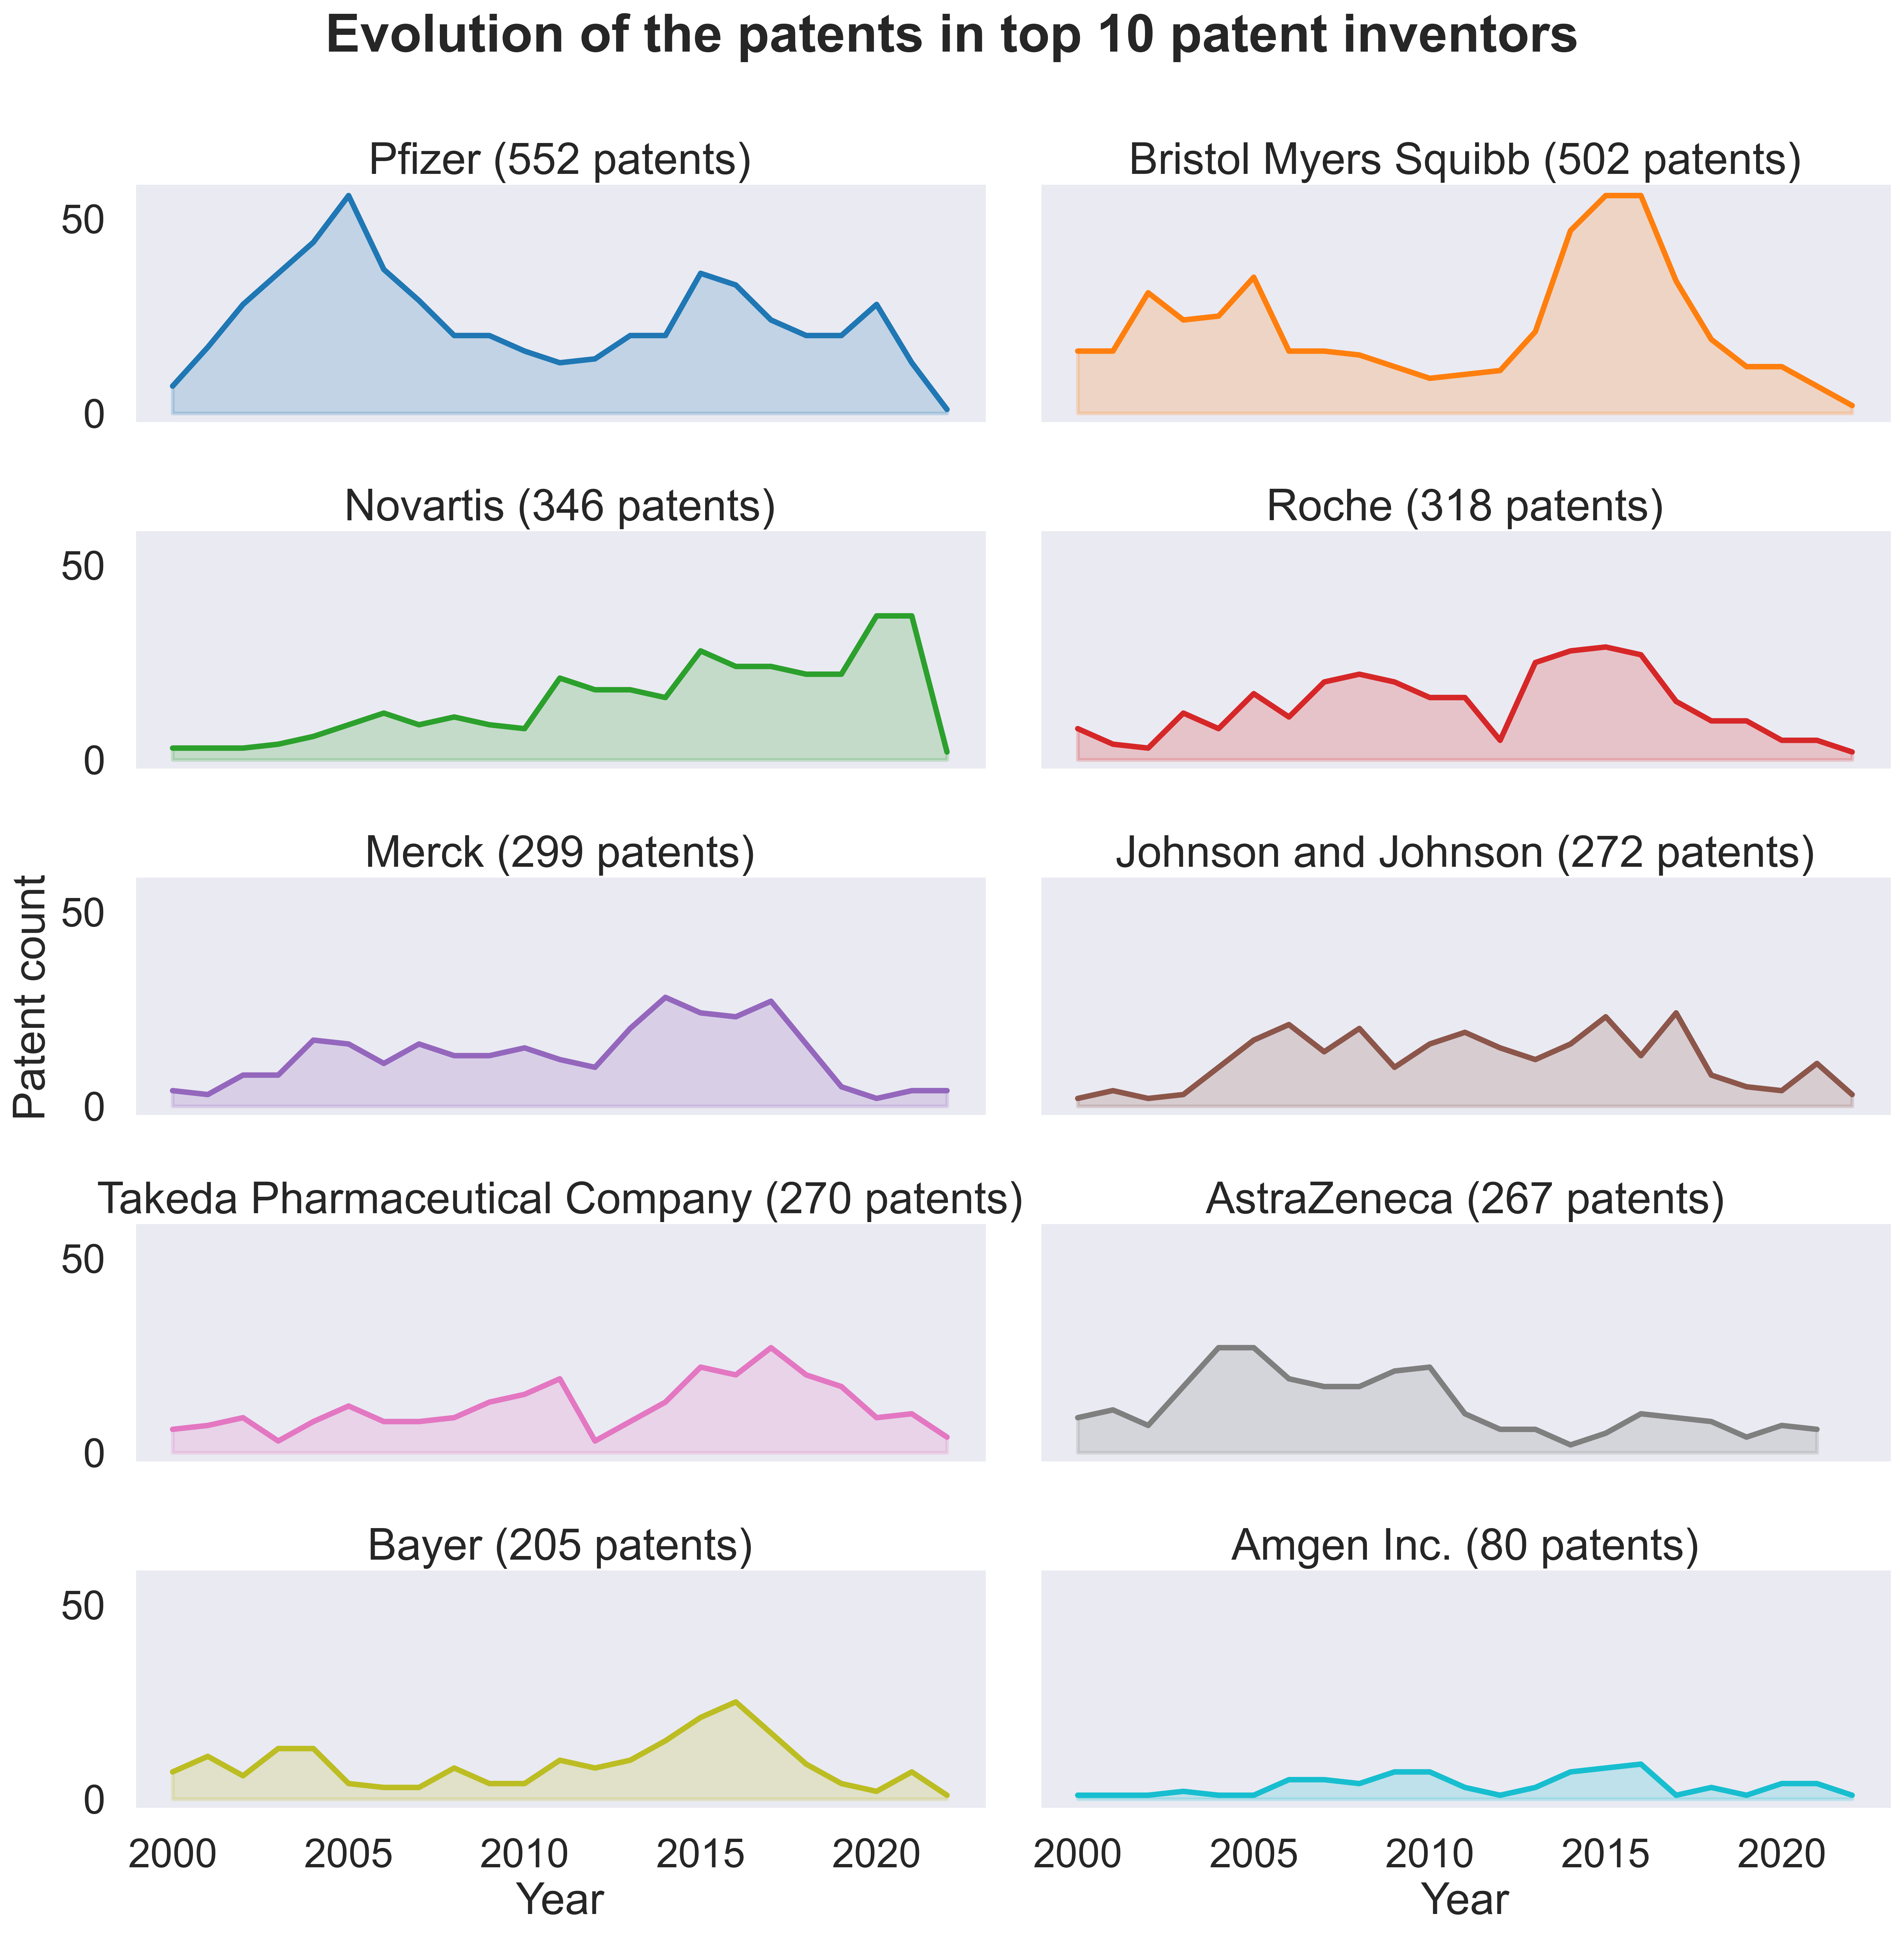

In [25]:
create_assignee_plot(top_assignee_alzheimers_disease, '7')

### Overview of top patent owners

In [26]:
k = top_assignee_rare_disease[['year', 'annual_patent_count']]
k = k.groupby('year').sum()
k.sort_values(by='year')
k.reset_index(inplace=True)

k['type'] = 'rare disease'


In [27]:
m = top_assignee_alzheimers_disease[['year', 'annual_patent_count']]
m = m.groupby('year').sum()
m.sort_values(by='year')
m.reset_index(inplace=True)

m['type'] = 'alzheimers disease'

In [28]:
p = pd.concat([k, m], ignore_index=True)
p.sort_values(by='year', inplace=True)
p.head(5)

year  annual_patent_count                type
0   2000                    3        rare disease
22  2000                   63  alzheimers disease
23  2001                   77  alzheimers disease
1   2001                    3        rare disease
24  2002                   98  alzheimers disease

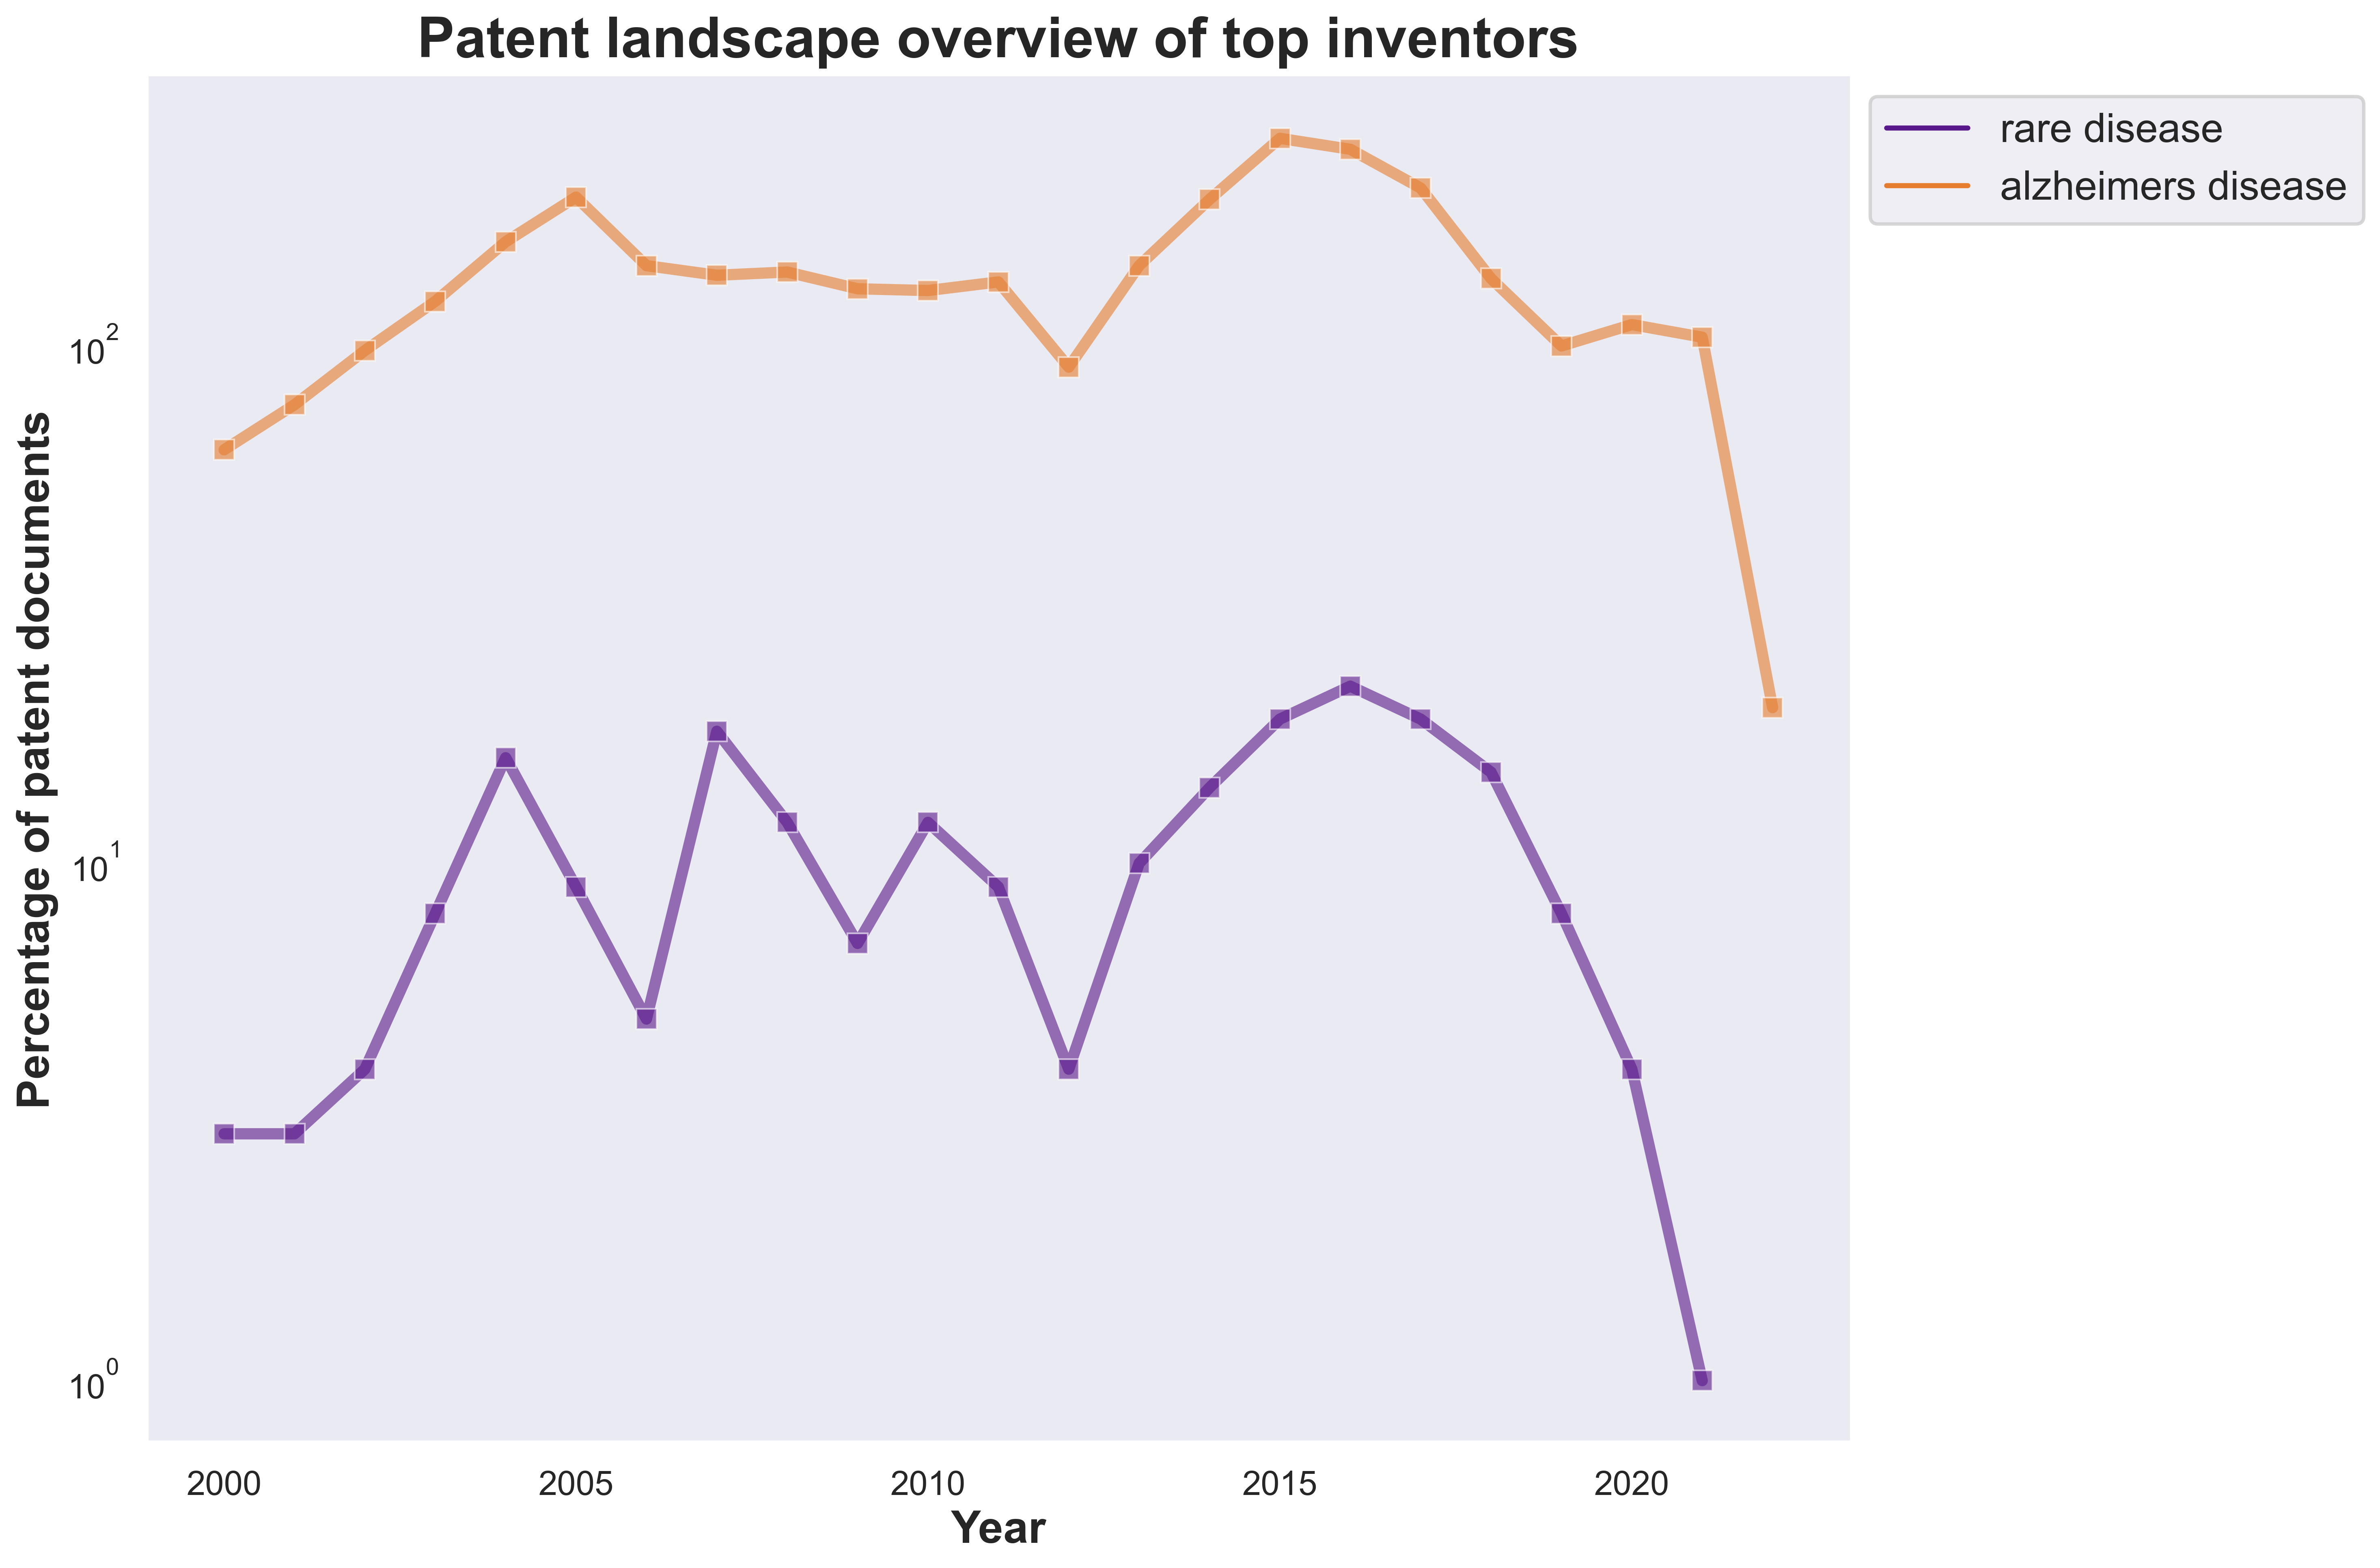

In [29]:
sns.set_context("talk")

plt.figure(figsize=(15, 10))

sns.lineplot(
    data=p,
    x='year', y='annual_patent_count',
    hue="type", marker="s", linewidth=5, palette=['#58178a', '#e67d2e'],
    alpha=0.6
)
plt.legend(markerscale=2)

sns.despine()

plt.title(
    "Patent landscape overview of top inventors", 
    horizontalalignment='center', size=25,
    verticalalignment='center', weight='bold', pad=15
)
plt.xlabel('Year', fontsize=20, weight='bold')
plt.ylabel('Percentage of patent documents', fontsize=20, weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 18})
plt.tight_layout()

plt.savefig(
    f'{FIG_DIR}/supplementary_figure_1.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()